## Collaborative Filtering: Matrix Factorization

- Example for Generalized Matrix Factorization (GMF) and Neural Matrix Factorization (NMF)

- In this example, we will explore building a MF model using explicit data (e.g. ratings). The scenario is given a dataset of users and courses they've viewed, recommend other courses a user may also be interested in. This example is basically a regression problem where we try to predict the ratings for each user and then recommend the highest predicted ratings. 

In [1]:
%cd ..

/Users/tracesmith/Desktop/Trace/Coding/user-recommender


In [85]:
%load_ext autoreload
%autoreload
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from recommenders.utils.plots import plot_metrics
from recommenders.matrix_factorization import get_recommendations
from recommenders.similarity import cosine_similarity,ApproximateTopRelated

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data

In [66]:
# Courses
items = pd.read_csv(os.path.join('data','course_tags.csv'))
items = items.rename(columns={'course_id':'item_id'})
                              
# Users
users = pd.read_csv(os.path.join('data','user_course_views.csv'))
users = users.rename(columns={'user_handle':'user_id',
                              'course_id':'item_id',
                              'view_time_seconds':'view_time'})

# Aggregate user viewing time --> viewed same course multiple times
users = users.groupby(['user_id','item_id','level'])['view_time'].sum().reset_index(drop=False)

### Drop courses with the lowest view time

In [67]:
thres = 5
min_views = users.groupby('user_id')['item_id'].count().reset_index(drop=False).rename(columns={'item_id':'count'})
users_filter = min_views[min_views['count'] < thres]['user_id'].tolist()
print('filter:',len(users_filter))

filter: 3940


In [73]:
users = users[~users['user_id'].isin(users_filter)].reset_index(drop=True)

### Unique Users/Items

In [69]:
unique_users = users['user_id'].unique()
unique_items = items['item_id'].unique()
print(unique_users.shape[0],unique_items.shape[0])

4820 5942


### Mappings for User/Items

In [70]:
# User Mappings
users_map = {i:val for i,val in enumerate(unique_users)}
users_inverse_map = {val:i for i,val in enumerate(unique_users)}

# Item Mappings
items_map = {i:val for i,val in enumerate(unique_items)}
items_inverse_map = {val:i for i,val in enumerate(unique_items)}

In [71]:
users['user_id_encoded'] = users['user_id'].map(users_inverse_map)
users['item_id_encoded'] = users['item_id'].map(items_inverse_map)
items['item_id_encoded'] = items['item_id'].map(items_inverse_map)

In [9]:
users.head()

,user_id,item_id,level,view_time,user_id_encoded,item_id_encoded
0,1,aws-certified-solutions-architect-professional,Advanced,102,0,587
1,1,aws-certified-sysops-admin-associate,Intermediate,83,0,588
2,1,aws-system-admin-fundamentals,Beginner,2665,0,607
3,1,cpt-sp2010-web-designers-branding-intro,Beginner,4884,0,1279
4,1,cpt-sp2010-web-designers-css,Intermediate,4959,0,1281


In [10]:
items[items['item_id'] == 'cpt-sp2010-web-designers-css']

,item_id,course_tags,item_id_encoded
2490,cpt-sp2010-web-designers-css,sharepoint,1281


### Create Explicit Data

In [11]:
ratings = users.copy()
ratings['rating'] = [np.random.randint(1,5) for i in range(ratings.shape[0])]

### Train/Test Split

In [12]:
def split_train_test(data:pd.DataFrame, split_ratio:float) -> np.ndarray:
    """ Split Train/Test Dataset"""
    idx = int(np.ceil(len(ratings) * split_ratio))
    train,test = data[:-idx], data[-idx:]
    print(f'Train Shape: {train.shape} -- Test Shape: {test.shape}')
    return train,test
    
train,test = split_train_test(ratings,split_ratio=0.20)

Train Shape: (77544, 7) -- Test Shape: (19386, 7)


### Matrix Factorization Model

[Reference](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/recommendation-systems/recommendation-systems.ipynb?utm_source=ss-recommendation-systems&utm_campaign=colab-external&utm_medium=referral&utm_content=recommendation-systems#scrollTo=_BlRIQJYo4tt)

Our goal is to factorize the ratings matrix $A$ into the product of a user embedding matrix $U$ and items embedding matrix $V$, such that $A \approx UV^\top$ with

$U = \begin{bmatrix} u_{1} \\ \hline \vdots \\ \hline u_{N} \end{bmatrix}$ and
$V = \begin{bmatrix} v_{1} \\ \hline \vdots \\ \hline v_{M} \end{bmatrix}$.

Here
- $N$ is the number of users,
- $M$ is the number of items,
- $A_{ij}$ is the rating of the $j$th items by the $i$th user,
- Each row $U_i$ is a $d$-dimensional vector (embedding) representing user $i$,
- Each row $V_j$ is a $d$-dimensional vector (embedding) representing items $j$,
- Predictions: for the $(i, j)$ pair is the dot product $\langle U_i, V_j \rangle$.

### Calculate Error

The model approximates the ratings matrix $A$ by a low-rank product $UV^\top$. We need a way to measure the approximation error. We'll start by using the Mean Squared Error of observed entries only (we will revisit this later). It is defined as

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$
where $\Omega$ is the set of observed ratings, and $|\Omega|$ is the cardinality of $\Omega$.

### Train Matrix Factorization Model using Stochastic Gradient Descent with Keras

- The user-movie rating matrix is high dimensional and sparse, therefore I am going to reduce the dimensionality to represent the data in a dense form.
- Using matrix factorisation a large matrix can be estimated/decomposed into two long but slim matrices. 
- With gradient descent it is possible to adjust these matrices to represent the given ratings. 
- The gradient descent algorithm finds latent variables which represent the underlying structure of the dataset. Afterwards these latent variables can be used to reconstruct the original matrix and to predict the missing ratings for each user.
- In this case the model has not been trained to convergence and is not hyperparameter optimized.

____
## Generalized Matrix Factorization (GMF)

- Ouput Layer = Dot Product

In [46]:
%autoreload
from recommenders.matrix_factorization import MatrixFactorization

In [47]:
MF = MatrixFactorization(unique_users,
                             unique_items,
                             embedding_dim=32,
                             epochs=50,
                             batch_size=256)

In [48]:
%autoreload
history = MF.train([train['user_id_encoded'],train['item_id_encoded']], train['rating'])
model = MF.model

Epoch 1/50
258/258 [==============================] - 1s 2ms/step - loss: 7.4861 - val_loss: 7.4298
Epoch 2/50
258/258 [==============================] - 0s 2ms/step - loss: 7.2862 - val_loss: 7.4289
Epoch 3/50
258/258 [==============================] - 0s 2ms/step - loss: 5.7657 - val_loss: 7.4226
Epoch 4/50
258/258 [==============================] - 0s 2ms/step - loss: 3.6646 - val_loss: 7.4182
Epoch 5/50
258/258 [==============================] - 0s 2ms/step - loss: 2.4993 - val_loss: 7.4179
Epoch 6/50
258/258 [==============================] - 1s 2ms/step - loss: 1.9024 - val_loss: 7.4190
Epoch 7/50
258/258 [==============================] - 1s 2ms/step - loss: 1.5717 - val_loss: 7.4202
Epoch 8/50
258/258 [==============================] - 0s 2ms/step - loss: 1.3705 - val_loss: 7.4215
Epoch 9/50
258/258 [==============================] - 0s 2ms/step - loss: 1.2349 - val_loss: 7.4226
Epoch 10/50
2424/2424 [==============================] - 2s 803us/step - loss: 1.9965


2021-08-01 20:52:00,533 - recommenders.matrix_factorization INFO - train mean squared error: 1.9965


### Evaluate Model

In [76]:
MF._evaluate([test['user_id_encoded'],test['item_id_encoded']], test['rating'], 'test')

606/606 [==============================] - 0s 787us/step - loss: 7.5040


2021-08-01 16:37:55,148 - recommenders.matrix_factorization INFO - test mean squared error: 7.5040


### Model Summary (GMF)

In [77]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 32)        154240      user[0][0]                       
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 32)        190144      item[0][0]                       
___________________________________________________________________________________________

### Recommend Similar Users

**Approximate Nearest Neighbor**

In [89]:
factors = model.get_weights()[0]
NN = ApproximateTopRelated(factors)
%time NN.get_related(idx=1)

CPU times: user 82 µs, sys: 1 µs, total: 83 µs
Wall time: 88 µs


[(1, 0.9998596805817215),
 (159, 0.4351388216018677),
 (933, 0.42210930585861206),
 (1935, 0.4214569330215454),
 (832, 0.4207218885421753),
 (1350, 0.390053927898407),
 (2702, 0.3681052327156067),
 (3094, 0.3662617802619934),
 (453, 0.35368824005126953),
 (1417, 0.35272449254989624)]

**Cosine Similarity**

In [54]:
%time similar_users = cosine_similarity(user=1,user_weights=model.get_weights()[0],top_k=5)
print('Similar Users:', similar_users)

CPU times: user 2.4 s, sys: 257 ms, total: 2.65 s
Wall time: 2.23 s
Similar Users: [2975 3100  330 2703 1466]


### Evaluate Model

/Users/tracesmith/Desktop/Trace/Coding/user-recommender/recommenders/utils/plots.py:22: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(n_rows, n_cols, idx + 1)


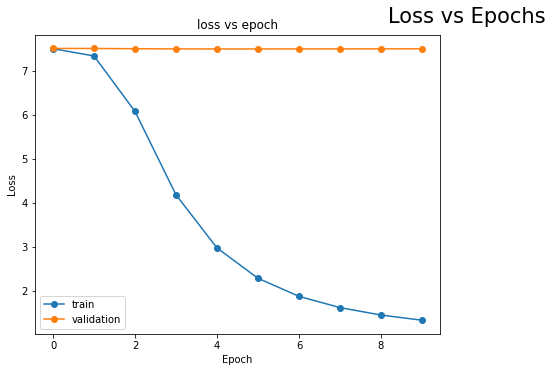

In [38]:
%autoreload
plot_metrics(history,metrics=['loss'])

### Make Recommendation

- Given an input user - return prediction of recommended items

In [100]:
get_recommendations(0,items['item_id_encoded'].unique(),items_map,model,5)

['character-rigging-production-maya-321',
 'introduction-houdini-digital-assets-2499',
 'unity-mobile-game-dev-lighting-lightmapping-606',
 'introduction-houdini-pyro-2504',
 'melee-weapon-systems-unity-659']

_______
## Deep Matrix Factorization (NMF)

- Ouput Layer = Non-linear 

In [92]:
%autoreload
from recommenders.matrix_factorization import DeepMatrixFactorization
NMF = NeuralMatrixFactorization(unique_users,
                             unique_items,
                             embedding_dim=64,
                             epochs=10,
                             batch_size=100, 
                             layers=[128,64,32,18],
                             dropout=0.10)

In [93]:
%autoreload
history2 = NMF.train([train['user_id_encoded'],train['item_id_encoded']], train['rating'])
model2 = NMF.model

Epoch 1/10
660/660 [==============================] - 3s 3ms/step - loss: 2.2303 - val_loss: 1.3468
Epoch 2/10
660/660 [==============================] - 2s 3ms/step - loss: 1.4263 - val_loss: 1.2881
Epoch 3/10
660/660 [==============================] - 2s 3ms/step - loss: 1.3591 - val_loss: 1.2988
Epoch 4/10
660/660 [==============================] - 2s 3ms/step - loss: 1.3152 - val_loss: 1.2915
Epoch 5/10
660/660 [==============================] - 2s 3ms/step - loss: 1.2867 - val_loss: 1.3010
Epoch 6/10
660/660 [==============================] - 2s 3ms/step - loss: 1.2619 - val_loss: 1.3079
Epoch 7/10
2424/2424 [==============================] - 3s 1ms/step - loss: 1.1838


2021-08-01 21:15:01,385 - recommenders.matrix_factorization INFO - train mean squared error: 1.1838


### Evaluate on Test Dataset

In [34]:
NMF._evaluate([test['user_id_encoded'],test['item_id_encoded']], test['rating'], 'test')

606/606 [==============================] - 1s 1ms/step - loss: 1.3237


2021-08-01 17:04:45,487 - recommenders.matrix_factorization INFO - test mean squared error: 1.3237


### Model Summary

In [23]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 64)        308480      user[0][0]                       
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 64)        380288      item[0][0]                       
____________________________________________________________________________________________

/Users/tracesmith/Desktop/Trace/Coding/user-recommender/recommenders/utils/plots.py:22: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(n_rows, n_cols, idx + 1)


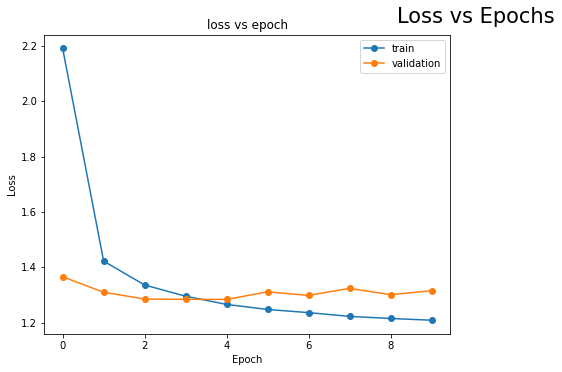

In [35]:
%autoreload
plot_metrics(history2,metrics=['loss'])

### Similar Users

**Approximate Nearest Neighbor**

In [100]:
factors2 = model2.get_weights()[0]
NN = ApproximateTopRelated(factors2)
%time NN.get_related(idx=0)

CPU times: user 109 µs, sys: 1e+03 ns, total: 110 µs
Wall time: 116 µs


[(0, 0.9997645245894091),
 (2755, 0.405689537525177),
 (106, 0.3864137530326843),
 (900, 0.38052642345428467),
 (245, 0.3763904571533203),
 (2710, 0.37345951795578003),
 (2077, 0.36551809310913086),
 (801, 0.3590085506439209),
 (2900, 0.35138005018234253),
 (3116, 0.35131603479385376)]

**Cosine Similarity**

In [101]:
%time similar_users = cosine_similarity(user=0,user_weights=model2.get_weights()[0],top_k=5)
print('Similar Users:', similar_users)

CPU times: user 1.98 s, sys: 273 ms, total: 2.25 s
Wall time: 1.82 s
Similar Users: [1599 1601 1602 1603 1604]


In [98]:
ratings[ratings['user_id_encoded'] == 0]

,user_id,item_id,level,view_time,user_id_encoded,item_id_encoded,rating
0,1,aws-certified-solutions-architect-professional,Advanced,102,0,587,4
1,1,aws-certified-sysops-admin-associate,Intermediate,83,0,588,1
2,1,aws-system-admin-fundamentals,Beginner,2665,0,607,1
3,1,cpt-sp2010-web-designers-branding-intro,Beginner,4884,0,1279,3
4,1,cpt-sp2010-web-designers-css,Intermediate,4959,0,1281,2
5,1,react-js-getting-started,Beginner,3593,0,4248,1


In [102]:
users[users['user_id_encoded'] == 2755].head()

,user_id,item_id,level,view_time,user_id_encoded,item_id_encoded
54421,5581,administrating-office-365-identities-70-346,Intermediate,357,2755,75
54422,5581,angular-application-development,Intermediate,1413,2755,290
54423,5581,angularjs-patterns-clean-code,Beginner,949,2755,308
54424,5581,exchange-2013-admin-adv-ft,Intermediate,1524,2755,1866
54425,5581,exchange-2013-admin-install,Intermediate,1850,2755,1868


### Make Recommendations

In [97]:
get_recommendations(1,items['item_id_encoded'].unique(),items_map,model2,5)

['understanding-java-vm-class-loading-reflection',
 'group-policy-fundamentals',
 'windows-server-2012-mcse-70-413',
 'v-ray-cinema-4d-look-development-photorealistic-interiors-2554',
 'mastering-java-swing-part1']